In [1]:
!pip install Pillow
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 136kB/s 
ERROR: umap-learn 0.4.4 has requirement scipy>=1.3.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [2]:
import base64
import numpy as np
import pandas as pd

# Plotly imports
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# Other imports
from collections import Counter
#from imageio import imread
from scipy.misc import imread
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
!unzip /content/spooky-author-identification.zip

Archive:  /content/spooky-author-identification.zip
  inflating: sample_submission.zip   
  inflating: test.zip                
  inflating: train.zip               


In [4]:
!unzip /content/train.zip

Archive:  /content/train.zip
  inflating: train.csv               


In [5]:
# Loading in the training data with Pandas
train = pd.read_csv("/content/train.csv")

In [6]:
print(train.shape)

(19579, 3)


In [19]:
from wordcloud import WordCloud, STOPWORDS

In [20]:
import nltk

In almost all Natural Language Processing (the field that explores interactions between a computer and human languages) tasks that you will come across (be it topic modelling, or word clustering or document-text classification etc), one will generally always have to undergo these few pre-processing steps to convert the input raw text into a form that is readable by your model and the machine. You certainly can't expect to feed a Random Forest model a paragraph of words and expect it to immediately predict which author that paragraph came from. Behind the scenes, text pre-processing can be boiled down to these few simple steps:

1.Tokenization - Segregation of the text into its individual constitutent words.

2.Stopwords - Throw away any words that occur too frequently as its frequency of occurrence will not be useful in helping detecting relevant texts. (as an aside also consider throwing away words that occur very infrequently).

3.Stemming - combine variants of words into a single parent word that still conveys the same meaning

4.Vectorization - Converting text into vector format. One of the simplest is the famous bag-of-words approach, where you create a matrix (for each document or text in the corpus). In the simplest form, this matrix stores word frequencies (word counts) and is oft referred to as vectorization of the raw text.

# Tokenization
The concept of tokenization is the act of taking a sequence of characters (think of Python strings) in a given document and dicing it up into its individual constituent pieces, which are the eponymous "tokens" of this method. One could loosely think of them as singular words in a sentence. One could naively implement the "split( )" method on a string which separates it into a python list based on the identifier in the argument. It is actually not that trivial to

Here we split the first sentence of the text in the training data just on a space as follows:

In [21]:
# Storing the first text element as a string
first_text = train.text.values[0]
print(first_text)
print("-"*90)
print(first_text.split(" "))

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
------------------------------------------------------------------------------------------
['This', 'process,', 'however,', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon;', 'as', 'I', 'might', 'make', 'its', 'circuit,', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out,', 'without', 'being', 'aware', 'of', 'the', 'fact;', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall.']


In [25]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [26]:
first_text_list = nltk.word_tokenize(first_text)
print(first_text_list)

['This', 'process', ',', 'however', ',', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', ';', 'as', 'I', 'might', 'make', 'its', 'circuit', ',', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out', ',', 'without', 'being', 'aware', 'of', 'the', 'fact', ';', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall', '.']


In [28]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Stopword Removal
As alluded to above stopwords are generally words that appear so commonly and at such a high frequency in the corpus that they don't actually contribute much to the learning or predictive process as a learning model would fail to distinguish it from other texts. Stopwordsinclude terms such as "to" or "the" and therefore, it would be to our benefit to remove them during the pre-processing phase. 

In [29]:
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)

179

In [30]:
first_text_list_cleaned = [word for word in first_text_list if word.lower() not in stopwords]
print(first_text_list_cleaned)
print("="*90)
print("Length of original list: {0} words\n"
      "Length of list after stopwords removal: {1} words"
      .format(len(first_text_list), len(first_text_list_cleaned)))

['process', ',', 'however', ',', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon', ';', 'might', 'make', 'circuit', ',', 'return', 'point', 'whence', 'set', ',', 'without', 'aware', 'fact', ';', 'perfectly', 'uniform', 'seemed', 'wall', '.']
Length of original list: 48 words
Length of list after stopwords removal: 28 words


# Stemming and Lemmatization
After removal of stopwords, the next stage of NLP that I would like to introduce is the process of Stemming. The work at this stage attempts to reduce as many different variations of similar words into a single term ( different branches all reduced to single word stem). Therefore if we have "running", "runs" and "run", you would really want these three distinct words to collapse into just the word "run". (However of course you lose granularity of the past, present or future tense).

We can turn to NLTK again which provides various stemmers which include variants such as the Porter stemming algorithm, the lancaster stemmer and the Snowball stemmer. In the following example, I will create a porter stemmer instance as follows:

In [31]:
stemmer = nltk.stem.PorterStemmer()

In [32]:
#And now we can use stemmer to see if it can reduce our these test words ("running", "runs", "run") 
#into their a single stemmed word. Conveniently we can test the stemmer on the fly as follows:

print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


As we can see, the stemmer has successfully reduced the given words above into a base form and this will be most in helping us reduce the size of our dataset of words when we come to learning and classification tasks.

However there is one flaw with stemming and that is the fact that the process involves quite a crude heuristic in chopping off the ends of words in the hope of reducing a particular word into a human recognizable base form. Therefore this process does not take into account vocabulary or word forms when collapsing words as this example will illustrate:

In [33]:
print("The stemmed form of leaves is: {}".format(stemmer.stem("leaves")))

The stemmed form of leaves is: leav


# Lemmatization to the rescue
Therefore we turn to another that we could use in lieu of stemming. This method is called lemmatization which aims to achieve the same effect as the former method. However unlike a stemmer, lemmatizing the dataset aims to reduce words based on an actual dictionary or vocabulary (the Lemma) and therefore will not chop off words into stemmed forms that do not carry any lexical meaning. Here we can utilize NLTK once again to initialize a lemmatizer (WordNet variant) and inspect how it collapses words as follows:

In [35]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [36]:
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))

The lemmatized form of leaves is: leaf


## **Vectorizing Raw Text**
In the vast collection of NLP literature, there are many different purposes for analyzing raw text, where in some cases you would like to compare the similarity of one body of text to another (Clustering techniques/Distance measurements), text classification (the purpose of this competition) as well as uncovering the topics that comprise a body of text (the aim of this notebook). With the purpose of uncovering topics at the back of our minds we must now think of how to feed the raw text into a machine learning model. Having already discussed tokenization, stopword removals and stemming (or maybe lemmatizing) we have now arrived at a reasonably cleaner text dataset then we started out with. However at this juncture, our raw text though human readable is still unfortunately not yet machine readable. A machine can read in bits and numbers and therefore we will first need to convert our text into numbers for which we utilise a very common approach known as the Bag-of-Words

The Bag of Words approach

This approach uses the counts of words as a starting block and records the occurrence of each word (from the entire text) in a vector specific to that particular word. For example given these two sentences "I love to eat Burgers", "I love to eat Fries", we first tokenize to obtain our vocabulary of 6 words from which we can get the word counts for - [I, love, to, eat, Burgers, Fries].

Vectorizing the text via the Bag of Words approach, we get six distinct vectors one for each word. So you ask since we now have rows consisting of numbers (instead of text) what forms the columns (or features)? Well each word now becomes an individual feature/column in this new transformed dataset. To illustrate this point, I shall utilize the Scikit-learn library to implement a vectorizer that generates a vector of word counts (term frequencies) - via the CountVectorizer method as follows.

In [37]:
# Defining our sentence
sentence = ["I love to eat Burgers", 
            "I love to eat Fries"]
vectorizer = CountVectorizer(min_df=0)
sentence_transform = vectorizer.fit_transform(sentence)

In [38]:
print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(sentence_transform.toarray()))

The features are:
 ['burgers', 'eat', 'fries', 'love', 'to']

The vectorized array looks like:
 [[1 1 0 1 1]
 [0 1 1 1 1]]


In [39]:
sentence_transform

<2x5 sparse matrix of type '<class 'numpy.longlong'>'
	with 8 stored elements in Compressed Sparse Row format>

I will implement two different topic modelling techniques as follows:

*Latent Dirichlet Allocation*
 Probabilistic, generative model which uncovers the topics latent to a dataset by assigning weights to words in a corpus, where each topic will assign different probability weights to each word.

*Non-negative Matrix Factorization*
 Approximation method that takes an input matrix and approximates the factorization of this matrix into two other matrices, with the caveat that the values in the matrix be non-negative.

In [40]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [41]:
#Extending the CountVectorizer class with a lemmatizer

lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [42]:
# Storing the entire training text in a list
text = list(train.text.values)
# Calling our overwritten Count vectorizer
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, 
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)


In [43]:
lda = LatentDirichletAllocation(n_components=11, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

In [44]:
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=11, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [46]:
n_top_words = 40
print("\nTopics in LDA model: ")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model: 

Topic #0:mean night fact young return great human looking wonder countenance difficulty greater wife finally set possessed regard struck perceived act society law health key fearful mr exceedingly evidence carried home write lady various recall accident force poet neck conduct investigation

Topic #1:death love raymond hope heart word child went time good man ground evil long misery replied filled passion bed till happiness memory heavy region year escape spirit grief visit doe story beauty die plague making influence thou letter appeared power

Topic #2:left let hand said took say little length body air secret gave right having great arm thousand character minute foot true self gentleman pleasure box clock discovered point sought pain nearly case best mere course manner balloon fear head going

Topic #3:called sense table suddenly sympathy machine sens unusual labour thrown mist solution suppose specie movement whispered urged frequent wine hour appears ring tu

In [49]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]
fourth_topic = lda.components_[3]

In [50]:
first_topic.shape

(13781,)

In [51]:
first_topic_words = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words = [tf_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
third_topic_words = [tf_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]
fourth_topic_words = [tf_feature_names[i] for i in fourth_topic.argsort()[:-50 - 1 :-1]]

Word Cloud visualizations of the topics

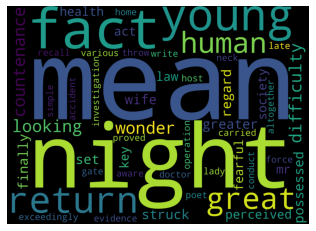

In [52]:
# Generating the wordcloud with the values under the category dataframe
firstcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(first_topic_words))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()


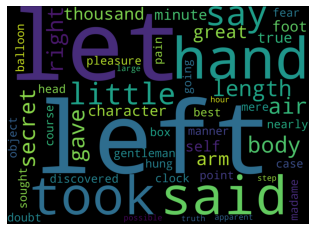

In [53]:
# Generating the wordcloud with the values under the category dataframe
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(third_topic_words))
plt.imshow(cloud)
plt.axis('off')
plt.show()